# Assignment 7: Transfer Learning


The goal of this exercise is to learn how to use pre-trained networks in transfer learning tasks.
We will make use of networks trained on ImageNet, and apply them to related problems, i.e., the classification of $10$ objects not contained in ImageNet.

## Dataset

For this exercise we use the  [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset that can be downloaded from the official website [here]({https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz}).
The dataset contains $60000$ color images of pixels size $32\times 32$ in $10$ classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck, with $6000$ images per class.

### Task 1: Data Transformation

We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.
We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$.

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [1]:
import torch
import torchvision

imagenet_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                std = [0.229, 0.224, 0.225])
    ]
)

### Task 2: Dataset Loading

We here use the [torchvision.datasets.CIFAR10](https://pytorch.org/vision/0.12/generated/torchvision.datasets.CIFAR10.html) dataset interface for processing images. 
You can use the `train` argument or flag to distinguish between training and test set.

This task consists of two parts:

1. Create two datasets, one for the training set, one for the test set. Use the transform defined above.
2. Once the datasets are created, create two data loaders, one for training set, one for test set. Use a proper value of the batch-size $B$.

In [2]:
trainset = torchvision.datasets.CIFAR10(
  root = "./data",
  train = True,
  transform = imagenet_transform,
  download = True
)

testset = torchvision.datasets.CIFAR10(
  root = "./data",
  train = False,
  transform = imagenet_transform,
  download = True
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12647815.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
B = 16
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size= B)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size= B)

### Test 1: Data Size and Types

We check that all input images are `torch.tensors` of size $3\times224\times224$ and of type `torch.float` and that all labels are of type `int`.

Note: the sanity check is only performed on the test set.

In [4]:
for x, t in testset:
  assert isinstance(x, torch.Tensor)
  assert isinstance(t, int)
  assert x.shape==(3,224,224)
  assert x.dtype==torch.float

## Deep Feature Extraction

We will use a pre-trained network available in `PyTorch`. 
Particularly, we will use a ResNet-50 architecture, but other architectures can also be tested. 
Fortunately, PyTorch provides simple interfaces to obtain pre-trained models, e.g., using the `torchvision.models.resnet50` interface function.

In order to use the networks in a different dataset, we need to change their outputs. 
There are several possibilities on how to achieve that, and you have the freedom to choose. 

For your reference, the implementation of the `forward` function of ResNet networks (including ResNet-50) can be found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L266

You can also check if other networks perform better, for example, deeper ResNet topologies.
Be aware that the strategy to replace the last fully-connected layer might not work in other network topologies, only in residual networks.

### Task 3: Pre-trained Network Instantiation

Instantiate two pre-trained networks of type ResNet-50.

1. Freeze the feature layers of the first network.

Note: Make use the `old TorchVision Interface` to load your pre-trained network. Here is the link: https://pytorch.org/vision/0.12/models.html 

In [5]:
# instantiate the first pre-trained resnet 50 network
network_1 = torchvision.models.resnet50(pretrained=True)
# Make sure to freeze all the layers of the network.
for param in network_1.parameters():
    param.requires_grad = False

# instantiate the second pre-trained resnet 50 network (optinally)
network_2 = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 318MB/s]


### Task 4: Network Implementation

We want to modify the network such that we extract the logits for the 10 classes from CIFAR-10 from the last fully-connected layer of the network.

Implement a function that:
1. Replaces the current last linear layer of the pre-trained network with a new linear layer that has $O$ units ($O$ represents the number of classes in our dataset).
2. Initialize the weights of the new linear layer using Xavier's method **(Optional)**.

Note: Use `torch.nn.init.xavier_uniform_` function to initialize the weights of the new linear layer.

In [6]:
def replace_last_layer(network, O=10):
  # replace the last linear layer with the new layer
  network.fc = torch.nn.Linear(512*4, O)
  torch.nn.init.xavier_uniform(network.fc.weight)
  return network

### Test 2: Last layer dimensions

This test ensures that the function return a network having the correct number of input and output units in the last layer.

In [7]:
O = 10
for network in (network_1, network_2):
    new_model = replace_last_layer(network, O=O)
    assert new_model.fc.out_features == O
    assert new_model.fc.in_features == 2048

<ipython-input-6-3dca934dff06>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(network.fc.weight)


## Network Training
Implement a function that takes all necessary parameters to run a training on a given dataset. 
Select the optimizer to be `torch.optim.SGD` and `torch.nn.CrossEntropyLoss` as the loss function. 
The test set will be used as the validation set.

### Task 5: Training and Evaluation Loop

Implement a training loop over a specific number of epochs (10) with a learning rate of $\eta=0.001$ and momentum of $\mu = 0.9$. 
Make sure that you train on the training data only, and `not` on the validation data.
In each loop, compute and print the training loss, training accuracy, validation loss and validation accuracy. 

In [61]:
import numpy
def train_eval(network, epochs=10, learning_rate=0.001, momentum=0.9):
  device = torch.device("cuda")
  network = network.to(device)
  optimizer = torch.optim.SGD(params=network.parameters(), lr=learning_rate, momentum=momentum)
  loss_fn = torch.nn.CrossEntropyLoss()

  train_loss, train_acc = [], []
  test_loss, test_acc = [], []

  for epoch in range(epochs):
    print("running for epoch:", epoch)

    # training process

    # set network mode to train
    network.train()
    # init 
    correct_pred = 0
    
    # loop over training data
    for inputs, labels in trainloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # predict output, backpropogate loss
      outputs = network(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      
      # statistics
      outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
      labels = labels.data.cpu().numpy()
      correct_pred += numpy.sum(outputs == labels)
    print(f"training acc: {correct_pred/len(trainset)}, training loss: {loss}")
    
    # testing process

    # set network to eval mode
    network.eval()
    #init
    test_pred = 0
    y_pred = []
    y_true = []


    # loop over testing data
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = network(inputs)
        loss = loss_fn(outputs, labels)

        # statistics
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        labels = labels.data.cpu().numpy()
        test_pred += numpy.sum(outputs == labels)
        y_pred.extend(outputs)
        y_true.extend(labels)
      print(f"validation acc: {test_pred/len(testset)}, validation loss: {loss}")
  return y_pred, y_true

### Task 6: Network Fine-Tuning with Frozen Layers

Create a network that has feature layers frozen with $10$ output units. 
Fine-tune the created network on our CIFAR-10 data using the previous function.

In [62]:
network_with_frozen_layers = replace_last_layer(network_1, O=10)
y_pred1, y_true1 = train_eval(network_with_frozen_layers)

<ipython-input-6-3dca934dff06>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(network.fc.weight)


running for epoch: 0
training acc: 0.68638, training loss: 0.8552505373954773
validation acc: 0.7558, validation loss: 0.9452900290489197
running for epoch: 1
training acc: 0.73582, training loss: 0.7353198528289795
validation acc: 0.7748, validation loss: 0.8671033382415771
running for epoch: 2
training acc: 0.7472, training loss: 1.0178254842758179
validation acc: 0.7787, validation loss: 0.7943891882896423
running for epoch: 3
training acc: 0.75542, training loss: 0.7259818911552429
validation acc: 0.7916, validation loss: 0.7610476613044739
running for epoch: 4
training acc: 0.75972, training loss: 0.6335304379463196
validation acc: 0.7803, validation loss: 0.7379048466682434
running for epoch: 5
training acc: 0.76162, training loss: 0.2932822108268738
validation acc: 0.7946, validation loss: 0.8247013092041016
running for epoch: 6
training acc: 0.76754, training loss: 0.8519880771636963
validation acc: 0.7907, validation loss: 0.8687633872032166
running for epoch: 7
training acc: 

### Task 7 (Optional): Network Fine-Tuning without Frozen Layers 

Create a network from the second pre-trained network with $10$ output units. 
Fine-tune the created network on our CIFAR-10.

Note:

  * The fine-tuning of the network can take a long time when the layers are not frozen.

In [63]:
network_normal = replace_last_layer(network_2, O=10)
y_pred2, y_true2 = train_eval(network_normal)

<ipython-input-6-3dca934dff06>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(network.fc.weight)


running for epoch: 0
training acc: 0.97638, training loss: 0.14326909184455872
validation acc: 0.9524, validation loss: 0.08673937618732452
running for epoch: 1
training acc: 0.98556, training loss: 0.0630740150809288
validation acc: 0.9533, validation loss: 0.21330419182777405
running for epoch: 2
training acc: 0.98866, training loss: 0.01352921687066555
validation acc: 0.9544, validation loss: 0.09616056084632874
running for epoch: 3
training acc: 0.9913, training loss: 0.031066564843058586
validation acc: 0.9424, validation loss: 0.6894593834877014
running for epoch: 4
training acc: 0.99162, training loss: 0.00440330570563674
validation acc: 0.9559, validation loss: 0.34798499941825867
running for epoch: 5
training acc: 0.99366, training loss: 0.0037946116644889116
validation acc: 0.9591, validation loss: 0.060631293803453445
running for epoch: 6
training acc: 0.99492, training loss: 0.11742719262838364
validation acc: 0.9508, validation loss: 0.43334680795669556
running for epoch: 

## Plotting

Finally, we want to plot the confusion matrix of the test set.
For this, we need to compute the predictions for all of our test samples, and the list of target values.
Finally, we can make use of the `sklearn.metrics.confusion_matrix` to compute the confusion matrix.
You can utilize `sklearn.metrics.ConfusionMatrixDisplay` for displaying the confusion matrix, or `pyplot.imshow` and adding the according labels.

Note:

  * The documentation for the confusion matrix can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  * The interface and an example for the `ConfusionMatrixDisplay` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

### Task 8: Confusion Matrix Plotting

Plot the confusion matrix for the fine-tuned network with frozen layers.
Optionally, also plot the confusion matrix for the second fine-tuned network.

<Axes: >

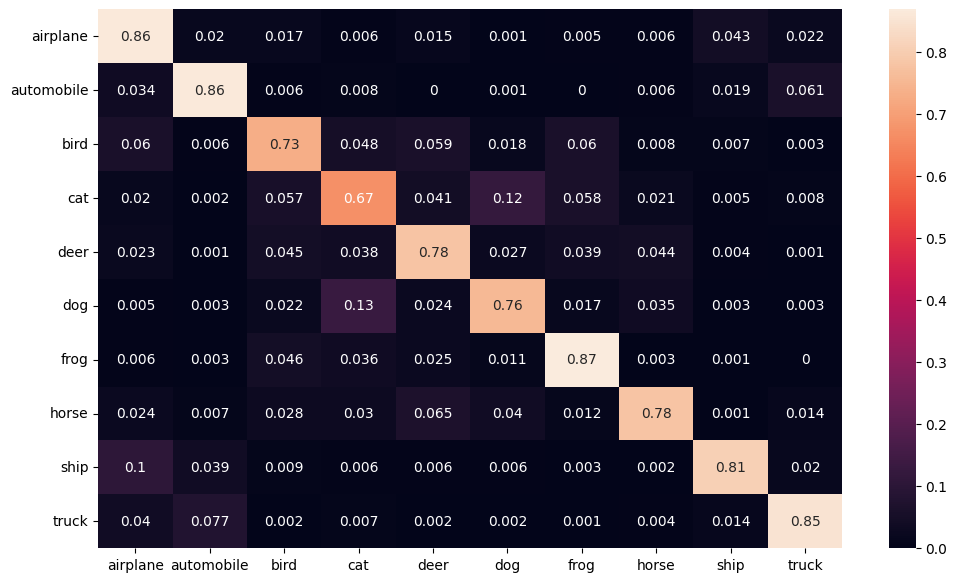

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# compute confusion matrix
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
matrix = confusion_matrix(y_true1, y_pred1)

# plot confusion matrix
df_cm = pd.DataFrame(matrix / np.sum(matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


<Axes: >

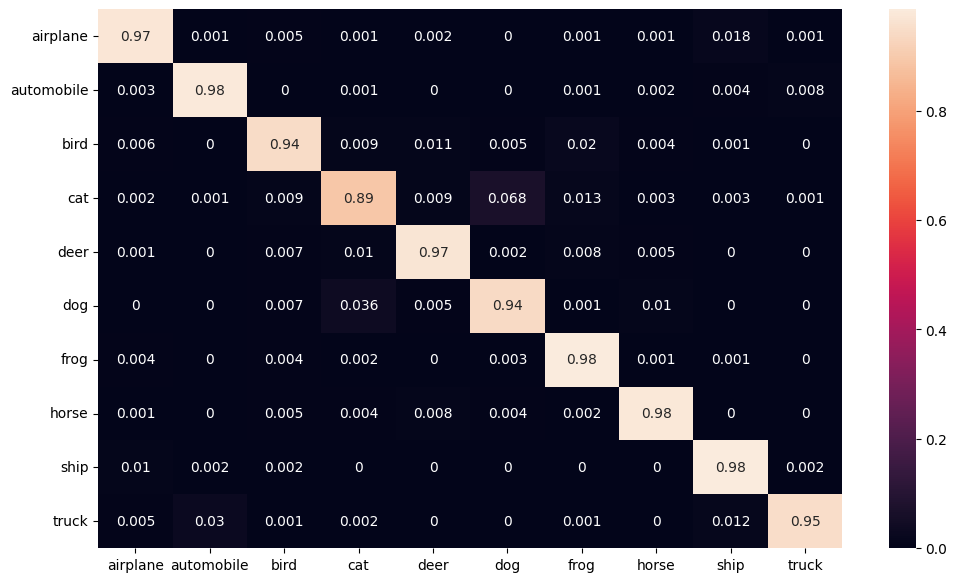

In [67]:
# compute confusion matrix for unfreezed network
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
matrix = confusion_matrix(y_true2, y_pred2)

# plot confusion matrix
df_cm = pd.DataFrame(matrix / np.sum(matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)